**You may need to install [OpenCV](https://pypi.python.org/pypi/opencv-python) and [scikit-video](http://www.scikit-video.org/stable/).**

In [19]:
import keras
import numpy as np
import io
import base64
from IPython.display import HTML
import skvideo.io
import cv2
import json

from keras.models import Sequential,model_from_json
from keras.layers.core import Dense
from keras.optimizers import sgd
from keras.layers import Conv2D, MaxPooling2D, Activation, AveragePooling2D,Reshape,BatchNormalization

from keras.optimizers import Adam
from keras.layers.core import Flatten

import matplotlib.pyplot as plt

# MiniProject #3: Deep Reinforcement Learning

__Notations__: $E_p$ is the expectation under probability $p$. Please justify each of your answer and widely comment your code.

# Context

In a reinforcement learning algorithm, we modelize each step $t$ as an action $a_t$ obtained from a state $s_t$, i.e. $\{(a_{t},s_{t})_{t\leq T}\}$ having the Markov property. We consider a discount factor $\gamma \in [0,1]$ that ensures convergence. The goal is to find among all the policies $\pi$, one that maximizes the expected reward:

\begin{equation*}
R(\pi)=\sum_{t\leq T}E_{p^{\pi}}[\gamma^t r(s_{t},a_{t})] \> ,
\end{equation*}

where: 
\begin{equation*}p^{\pi}(a_{0},a_{1},s_{1},...,a_{T},s_{T})=p(a_{0})\prod_{t=1}^{T}\pi(a_{t}|s_{t})p(s_{t+1}|s_{t},a_{t}) \> .
\end{equation*}

[Note : I assumed there was a small typo in the indices here, but without consequences

\begin{equation*}p^{\pi}(s_{0},a_{0}, s_{1},a_{1},...,s_{T-1},a_{T-1},s_{T})=p(s_{0})\prod_{t=0}^{T-1}\pi(a_{t}|s_{t})p(s_{t+1}|s_{t},a_{t}) \> .
\end{equation*}]

We note the $Q$-function:

\begin{equation*}Q^\pi(s,a)=E_{p^{\pi}}[\sum_{t\leq T}\gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a] \> .
\end{equation*}

Thus, the optimal Q function is:
\begin{equation*}
Q^*(s,a)=\max_{\pi}Q^\pi(s,a) \> .
\end{equation*}

In this project, we will apply the deep reinforcement learning techniques to a simple game: an agent will have to learn from scratch a policy that will permit it maximizing a reward.

## The environment, the agent and the game

### The environment

```Environment``` is an abstract class that represents the states, rewards, and actions to obtain the new state.

In [20]:
class Environment(object):
    def __init__(self):
        pass

    def act(self, act):
        """
        One can act on the environment and obtain its reaction:
        - the new state
        - the reward of the new state
        - should we continue the game?

        :return: state, reward, game_over
        """
        pass


    def reset(self):
        """
        Reinitialize the environment to a random state and returns
        the original state

        :return: state
        """
        pass
    
    def draw(self):
        """
        Visualize in the console or graphically the current state
        """
        pass

The method ```act``` allows to act on the environment at a given state $s_t$ (stored internally), via action $a_t$. The method will return the new state $s_{t+1}$, the reward $r(s_{t},a_{t})$ and determines if $t\leq T$ (*game_over*).

The method ```reset``` simply reinitializes the environment to a random state $s_0$.

The method ```draw``` displays the current state $s_t$ (this is useful to check the behavior of the Agent).

We modelize $s_t$ as a tensor, while $a_t$ is an integer.

### The Agent

The goal of the ```Agent``` is to interact with the ```Environment``` by proposing actions $a_t$ obtained from a given state $s_t$ to attempt to maximize its __reward__ $r(s_t,a_t)$. We propose the following abstract class:

In [21]:
class Agent(object):
    def __init__(self, epsilon=0.1, n_action=4):
        self.epsilon = epsilon
        self.n_action = n_action
    
    def set_epsilon(self,e):
        self.epsilon = e

    def act(self,s,train=True):
        """ This function should return the next action to do:
        an integer between 0 and 4 (not included) with a random exploration of epsilon"""
        if train:
            if np.random.rand() <= self.epsilon:
                a = np.random.randint(0, self.n_action, size=1)[0]
            else:
                a = self.learned_act(s)
        else:
            a = self.learned_act(s)

        return a

    def learned_act(self,s):
        """ Act via the policy of the agent, from a given state s
        it proposes an action a"""
        pass

    def reinforce(self, s, n_s, a, r, game_over_):
        """ This function is the core of the learning algorithm. 
        It takes as an input the current state s_, the next state n_s_
        the action a_ used to move from s_ to n_s_ and the reward r_.
        
        Its goal is to learn a policy.
        """
        pass

    def save(self):
        """ This function returns basic stats if applicable: the
        loss and/or the model"""
        pass

    def load(self):
        """ This function allows to restore a model"""
        pass

***
__Question 1__:
Explain the function act. Why is ```epsilon``` essential?

> At train time (train = True) : With a probability epsilon, the agent chooses an action uniformly at random (exploration). Otherwise (with a probability 1-epsilon) it chooses the action maximizing the expected cumulative reward from his current state, ie. the Q-value of the pair state-action (exploitation). 

> Thus epsilon is essential as it **tradeoffs between exploration of the environment and exploitation of the learnt policy**. A current habit is thus to decrease epsilon throughout the learning (favor exploitation over exploration as the agent learns).

> At test time  (train = False) : The agent follows the learnt policy, ie. chooses the action maximizing the expected cumulative reward from his current state, ie. the Q-value of the pair state-action (only exploitation).

***
### The Game

The ```Agent``` and the ```Environment``` work in an interlaced way as in the following (take some time to understand this code as it is the core of the project)

```python

epoch = 300
env = Environment()
agent = Agent()


# Number of won games
score = 0
loss = 0


for e in range(epoch):
    # At each epoch, we restart to a fresh game and get the initial state
    state = env.reset()
    # This assumes that the games will end
    game_over = False

    win = 0
    lose = 0
    
    while not game_over:
        # The agent performs an action
        action = agent.act(state)

        # Apply an action to the environment, get the next state, the reward
        # and if the games end
        prev_state = state
        state, reward, game_over = env.act(action)

        # Update the counters
        if reward > 0:
            win = win + reward
        if reward < 0:
            lose = lose -reward

        # Apply the reinforcement strategy
        loss = agent.reinforce(prev_state, state,  action, reward, game_over)

    # Save as a mp4
    if e % 10 == 0:
        env.draw(e)

    # Update stats
    score += win-lose

    print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
          .format(e, epoch, loss, win, lose, win-lose))
    agent.save()
```

# The game, *eat cheese*

A rat runs on an island and tries to eat as much as possible. The island is subdivided into $N\times N$ cells, in which there are cheese (+0.5) and poisonous cells (-1). The rat has a visibility of 2 cells (thus it can see $5^2$ cells). The rat is given a time $T$ to accumulate as much food as possible. It can perform 4 actions: going up, down, left, right. 

The goal is to code an agent to solve this task that will learn by trial and error. We propose the following environment:

In [22]:
class Environment(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        grid_size = grid_size+4
        self.grid_size = grid_size
        self.max_time = max_time
        self.temperature = temperature

        # board on which one plays
        self.board = np.zeros((grid_size,grid_size))
        self.position = np.zeros((grid_size,grid_size))

        # coordinate of the cat
        self.x = 0
        self.y = 1

        # self time
        self.t = 0

        self.scale=16

        self.to_draw = np.zeros((max_time+2, grid_size*self.scale, grid_size*self.scale, 3))


    def draw(self,e):
        skvideo.io.vwrite(str(e) + '.mp4', self.to_draw)

    def get_frame(self,t):
        b = np.zeros((self.grid_size,self.grid_size,3))+128
        b[self.board>0,0] = 256
        b[self.board < 0, 2] = 256
        b[self.x,self.y,:]=256
        b[-2:,:,:]=0
        b[:,-2:,:]=0
        b[:2,:,:]=0
        b[:,:2,:]=0
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        self.to_draw[t,:,:,:]=b


    def act(self, action):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[:, -2:] = -1 #self.position[-2:, :] = -1

        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size-3:
                self.x = self.x -1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x +1
            else:
                self.x = self.x - 1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        reward = self.board[self.x, self.y]
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        state = np.concatenate((self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]
        
        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]


        bonus = 0.5*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size,self.grid_size)

        malus = -1.0*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))


        malus[bonus>0]=0

        self.board = bonus + malus

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[:, -2:] = -1
        
        self.board[self.x,self.y] = 0
        self.board[self.position < 0] = 0
        
        self.t = 0

        state = np.concatenate((
                               self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state

The following elements are important because they correspond to the hyper parameters for this project:

In [23]:
# parameters
size = 13
T=200
temperature= 0.3 
epochs_train=100 # set small when debugging
epochs_test=50  # set small when debugging

# display videos
def display_videos(name):
    video = io.open(name, 'r+b').read()
    encoded = base64.b64encode(video)
    return '''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))

__Question 2__ Explain the use of the arrays ```position``` and ```board```.

> The array position gives to the rat the information of where it can go (0 if the cell is accessible and -1 if not). We also store in the array the position of the rat (value of 1).

> The array board gives to the rat the current positions of the cheese and poisonous cells in the environment (value of 0.5 if there is a cheese in the cell, of -1 if it is a poison, 0 if there is nothing). 

> Cheeses and poisons are initially generated at each episode as follows : (i) each cell has a probability temperature to contain a cheese, (ii) once cheese are generated, each cell which does not contain a cheese has a probability temperature to contain a poison.

> Note : I modified several things in the code : first, i added the border at the right of the board (missing) ; secondly, i removed any cheese/poison in the border zones ; finally, i decided to remove the bouncing effects of the rat on the borders (now the rat stays in the same position if it can't go in the action direction because of a border.  Indeed, otherwise, it would have receive a wrong feedback given the potential reward in the cell of arrival).

## Random Agent

***
__Question 3__ Implement a random Agent (only ```learned_act``` needs to be implemented):

In [24]:
class RandomAgent(Agent):
    def __init__(self):
        super(RandomAgent, self).__init__()
        pass

    def learned_act(self, s):
        return np.random.randint(0, self.n_action)

***
***
__Question 4__ Visualize the game moves. You need to fill in the following function for the evaluation:

In [25]:
def test(agent,env,epochs,prefix='',return_trajectories=False):
    
    if return_trajectories:
        trajectories = []
        
    score = 0
        
    for e in range(epochs):
                
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will end
        game_over = False

        win = 0
        lose = 0

        while not game_over:
                        
            # The agent performs an action
            action = agent.act(state, train=False)
            
            # Apply an action to the environment, get the next state, the reward
            prev_state = state
            state, reward, game_over = env.act(action)
            
            if return_trajectories:
                trajectories.append((prev_state,action))

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose - reward
        
        # Save as a mp4
        env.draw(prefix+str(e))

        # Update stats
        score_episode = 0.5*win-lose
        score += score_episode

        print("Win/lose count {}/{}. Average score ({})"
              .format(win, lose, score/(1+e)))
    print('Final score: '+str(score/epochs))
    
    if return_trajectories:
        return trajectories

Note : As score measure, I used 0.5*win - lose instead of win-lose since poison give a reward of -1 while cheese 0.5.

In [26]:
# Initialize the game
env = Environment(grid_size=size, max_time=T,temperature=temperature)

# Initialize the agent!
agent = RandomAgent()

test(agent,env,epochs_test,prefix='random')
HTML(display_videos('random0.mp4'))

Win/lose count 6.5/14.0. Average score (-10.75)
Win/lose count 9.0/14.0. Average score (-10.125)
Win/lose count 9.5/21.0. Average score (-12.166666666666666)
Win/lose count 10.5/22.0. Average score (-13.3125)
Win/lose count 7.5/10.0. Average score (-11.9)
Win/lose count 9.5/11.0. Average score (-10.958333333333334)
Win/lose count 11.0/14.0. Average score (-10.607142857142858)
Win/lose count 8.5/15.0. Average score (-10.625)
Win/lose count 17.5/12.0. Average score (-9.805555555555555)
Win/lose count 9.5/10.0. Average score (-9.35)
Win/lose count 8.0/15.0. Average score (-9.5)
Win/lose count 11.0/12.0. Average score (-9.25)
Win/lose count 8.0/9.0. Average score (-8.923076923076923)
Win/lose count 12.0/15.0. Average score (-8.928571428571429)
Win/lose count 7.0/13.0. Average score (-8.966666666666667)
Win/lose count 11.5/14.0. Average score (-8.921875)
Win/lose count 9.5/14.0. Average score (-8.941176470588236)
Win/lose count 10.0/15.0. Average score (-9.0)
Win/lose count 8.5/10.0. Averag

***
## DQN

Let us assume here that $T=\infty$.

***
__Question 5__ Let $\pi$ be a policy, show that:

\begin{equation*}
Q^{\pi}(s,a)=E_{(s',a')\sim p(.|s,a)}[r(s,a)+\gamma Q^{\pi}(s',a')]
\end{equation*}

Then, show that for the optimal policy $\pi^*$ (we assume its existence), the following holds: 

\begin{equation*}
Q^{*}(s,a)=E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q^{*}(s',a')].
\end{equation*}
Finally, deduce that a plausible objective is:

\begin{equation*}
\mathcal{L}(\theta)=E_{s' \sim \pi^*(.|s,a)}\Vert r+\gamma\max\max_{a'}Q(s',a',\theta)-Q(s,a,\theta)\Vert^{2}.
\end{equation*}


> I assumed there were small typos in the assertions to prove. Let us rewrite the question first : 

> 1. Let $\pi$ be a policy, show that: \begin{equation*}
Q^{\pi}(s,a)=E_{s'\sim p(.|s,a), ~a' \sim \pi(.|s')}[r(s,a)+\gamma Q^{\pi}(s',a')]
\end{equation*}

> 2. Then, show that for the optimal policy $\pi^*$ (we assume its existence), the following holds:  \begin{equation*}
Q^{*}(s,a)=E_{s'\sim p(.|s,a)}[r(s,a)+\gamma \max_{a'} Q^{*}(s',a')]
\end{equation*}

> 3. Finally, deduce that a plausible objective is:
\begin{equation*}
\mathcal{L}(\theta)=E_{s' \sim p(.|s,a)}\Vert r(s,a) +\gamma \max_{a'}Q(s',a',\theta)-Q(s,a,\theta)\Vert^{2}
\end{equation*}


***

> **Question 1**

> $Q^{\pi}(s,a)$ is defined as the expected cumulative reward over trajectories beginning in state $s$ with action $a$ and following policy $\pi$. We can rewrite it as :


> \begin{align} Q^\pi(s,a) &=E_{p^{\pi}}[\sum_{t\leq T}\gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a]
\\ &= r(s, a) + \gamma E_{p^{\pi}}[\sum_{1 \leq t \leq T} \gamma^{t - 1} r(s_t,a_t)|s_0=s,a_0=a] 
\\ &= r(s, a) + \gamma \sum_{s'} \mathbb{P}(s_1 = s' | s_0 = s,a_0=a) \sum_{a'} \pi(a'|s') E_{p^{\pi}}[\sum_{1 \leq t \leq T} \gamma^{t - 1} r(s_t,a_t)|s_1=s',a_1=a']
\\ &= r(s, a) + \gamma \sum_{s'} \mathbb{P}(s_1 = s' | s_0 = s,a_0=a) \sum_{a'} \pi(a'|s') E_{p^{\pi}}[\sum_{0 \leq t \leq T-1} \gamma^{t} r(s_t,a_t)|s_0=s',a_0=a'] \\
 & = r(s,a) + \gamma \sum_{s'} p(s'|s,a) \sum_{a'} \pi(a'|s')  Q^{\pi}(s',a')\end{align}


> This is the so-called Bellman equation (which tells that the expected discounted cumulative reward in state s taking action a is the sum of the immediate reward $r(s,a)$ and of the expectation of the discounted cumulative reward over all new reachable state $s' \sim p(.|s,a)$ and taking action from state $s'$ following the policy $\pi$ (ie. choosing $a' \sim \pi(.|s')$)).

> Then, $$\begin{align}
Q^{\pi}(s,a)& = r(s,a) + \gamma \sum_{s'} p(s'|s,a) \sum_{a'} \pi(a'|s')  Q^{\pi}(s',a') \\
&= \sum_{s'} p(s'|s,a) \left( r(s,a) + \gamma \sum_{a'} \pi(a'|s')  Q^{\pi}(s',a')\right) \\
&= \sum_{s'} p(s'|s,a) \sum_{a'} \pi(a'|s')  \left( r(s,a) + \gamma Q^{\pi}(s',a') \right) \\
&=E_{s'\sim p(.|s,a), ~a' \sim \pi(.|s')}[r(s,a)+\gamma Q^{\pi}(s',a')].
\end{align}$$ 


***

> **Question 2**


> Denoting $Q^{*} = Q^{\pi^*}$ the state-action value function associated to the optimal policy, 

$$\begin{align}
Q^{*}(s,a) &= E_{s'\sim p(.|s,a), ~a' \sim \pi(.|s')}[r(s,a)+\gamma Q^{*}(s',a')] \\
&=E_{s'\sim p(.|s,a)}   \left[ r(s,a) + \gamma  \sum_{a'} \pi(a'|s') Q^{*}(s',a') \right].
\end{align}$$ 


> But the optimal policy $\pi^*$ satisfies for any action $a$ : $$\pi^*(a|s) = 1_{a = a_0} $$ where we set : $$a_0 = \arg \max_{a} Q^{*}(s,a)$$

> Hence : $$\begin{align}
Q^{*}(s,a) &= E_{s'\sim p(.|s,a)} \left[ r(s,a)+\gamma Q^{*} \left( s',\arg \max_{a'} Q^{*}(s',a') \right) \right] \\
&=E_{s'\sim p(.|s,a)}[r(s,a)+\gamma \max_{a'} Q^{*}(s',a')] \end{align}$$ 

*** 

> **Question 3**

> Hence :  $$ E_{s'\sim p(.|s,a)}[r(s,a)+\gamma \max_{a'} Q^{*}(s',a')- Q^{*}(s,a) ] = 0 $$

> Therefore, such matrix $Q^{*}$ will minimize the following loss : \begin{equation*}
\mathcal{L}(\theta)=E_{s' \sim p(.|s,a)}\Vert r(s,a) +\gamma \max_{a'}Q(s',a',\theta)-Q(s,a,\theta)\Vert^{2}.
\end{equation*}


***
The DQN-learning algorithm relies on these derivations to train the parameters $\theta$ of a Deep Neural Network:

1. At the state $s_t$, select the action $a_t$ with best reward using $Q_t$ and store the results;

[Note : I assumed that at state $s_t$, we select the action $a_t$ following an epsilon-greedy policy (ie. the one with highest $Q_t$ value with probability 1-epsilon, and uniformly at random otherwise]

2. Obtain the new state $s_{t+1}$ from the environment $p$;

3. Store $(s_t,a_t,s_{t+1})$;

4. Obtain $Q_{t+1}$ by minimizing  $\mathcal{L}$ from a recovered batch from the previously stored results.

***
__Question 6__ Implement the class ```Memory``` that stores moves (in a replay buffer) via ```remember``` and provides a ```random_access``` to these. Specify a maximum memory size to avoid side effects. You can for example use a ```list()``` and set by default ```max_memory=100```.

In [27]:
class Memory(object):
    def __init__(self, max_memory=100):
        self.max_memory = max_memory
        self.memory = list()

    def remember(self, m):
        self.memory.append(m)
        if len(self.memory)>self.max_memory:
            self.memory = self.memory[-self.max_memory:]

    def random_access(self):
        #len_memory = len(self.memory)
        #idx = np.random.permutation(len_memory)
        #return self.memory[idx]
        idx = np.random.randint(len(self.memory))
        return self.memory[idx]

***
The pipeline we will use for training is given below:

In [28]:
def train(agent,env,epoch,prefix=''):
    
    history_losses = []
    history_scores = []    
    
    score = 0
    
    for e in range(epoch):
            
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False
        
        loss = 0

        win = 0
        lose = 0
        
        t = 0

        while not game_over:
            
            # The agent performs an action
            action = agent.act(state, train=True)

            # Apply an action to the environment, get the next state, the reward
            prev_state = state
            state, reward, game_over = env.act(action)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose - reward

            # Apply the reinforcement strategy
            loss += agent.reinforce(prev_state, state,  action, reward, game_over)
            
            t+=1
            
        loss /= t
            
        history_losses.append(loss)

        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix+str(e))

        # Update stats
        score_episode = 0.5*win-lose
        score += score_episode
        history_scores.append(score_episode)

        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
              .format(e, epoch, loss, win, lose, score_episode))
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')
        
    return history_losses, history_scores

***
__Question 7__ Implement the DQN training algorithm using a cascade of fully connected layers. You can use different learning rate, batch size or memory size parameters. In particular, the loss might oscillate while the player will start to win the games. You have to find a good criterium.

In [29]:
class DQN(Agent):
    def __init__(self, grid_size = 10.,  epsilon = 0.1, memory_size=100, batch_size = 16, n_state=2):
        super(DQN, self).__init__(epsilon = epsilon)

        # Discount for Q learning
        self.discount = 0.99
        
        self.grid_size = grid_size
        
        # number of state
        self.n_state = n_state

        # Memory
        self.memory = Memory(memory_size)
        
        # Batch size when learning
        self.batch_size = batch_size

    def learned_act(self, s):
        state_action_values = self.model.predict(s[None,:,:,:]).flatten()
        return np.argmax(state_action_values)

    def reinforce(self, s_, n_s_, a_, r_, game_over_):
        # Two steps: first memorize the states, second learn from the pool

        self.memory.remember([s_, n_s_, a_, r_, game_over_])
        
        input_states = np.zeros((self.batch_size, 5, 5, self.n_state))
        
        steps = [self.memory.random_access() for i in range(self.batch_size)]
        
        #states
        input_states = [s[0] for s in steps]
        input_states = np.array(input_states)
        
        #new_state, action, rew, game_over 
        tmp = np.array([s[1:] for s in steps])
        new_states = tmp[:,0]
        actions = tmp[:,1]
        rewards = tmp[:,2]
        game_over = tmp[:,3]
        
        print(input_states.shape, tmp.shape)
        print(np.max(q_new_state,axis=1).shape)
        
        # targets
        target_q = self.model.predict(input_states)
        q_new_state = self.model.predict(new_states)
        target_q[np.arange(self.batch_size),actions] = rew + (1-game_over) * self.discount * np.max(q_new_state,axis=1)
        
        # HINT: Clip the target to avoid exploiding gradients.. -- clipping is a bit tighter        
        target_q = np.clip(target_q, -3, 3)

        #early_stopping_monitor = EarlyStopping(patience = 5)
        l = self.model.train_on_batch(input_states, target_q)

        return l

    def save(self,name_weights='model.h5',name_model='model.json'):
        self.model.save_weights(name_weights, overwrite=True)
        with open(name_model, "w") as outfile:
            json.dump(self.model.to_json(), outfile)
            
    def load(self,name_weights='model.h5',name_model='model.json'):
        with open(name_model, "r") as jfile:
            model = model_from_json(json.load(jfile))
        model.load_weights(name_weights)
        
        #model.compile("sgd", "mse")
        model.compile("adam", "mse")
        
        self.model = model


class DQN_FC(DQN):
    def __init__(self, lr=0.1, *args, **kwargs):
        super(DQN_FC, self).__init__(*args,**kwargs)
        
        # NN Model
        
        model = Sequential()
        model.add(Flatten(input_shape = (5,5,self.n_state,)))
        model.add(Dense(20))
        model.add(Activation('relu'))
        model.add(Dense(self.n_action))
        
        model.summary()
        
        #opt = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        opt = sgd(lr=lr, decay=1e-4, momentum=0.0)
        model.compile(loss="mse", optimizer = opt)
        self.model = model

In [30]:

env = Environment(grid_size=size, max_time=T, temperature=temperature)
agent_dqn_fc = DQN_FC(grid_size=size, lr=.01, epsilon = 0.01, memory_size=2000, batch_size = 32)
history_losses_dqn_fc, history_scores_dqn_fc = train(agent_dqn_fc, env, epochs_train, prefix='fc_train')

HTML(display_videos('fc_train10.mp4'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 20)                1020      
_________________________________________________________________
activation_4 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 84        
Total params: 1,104
Trainable params: 1,104
Non-trainable params: 0
_________________________________________________________________
Epoch 000/100 | Loss 0.0157 | Win/lose count 3.0/1.0 (0.5)
Epoch 001/100 | Loss 0.0125 | Win/lose count 0.5/1.0 (-0.75)
Epoch 002/100 | Loss 0.0077 | Win/lose count 0.5/1.0 (-0.75)
Epoch 003/100 | Loss 0.0122 | Win/lose count 0.5/0 (0.25)
Epoch 004/100 | Loss 0.0059 | Win

No handles with labels found to put in legend.


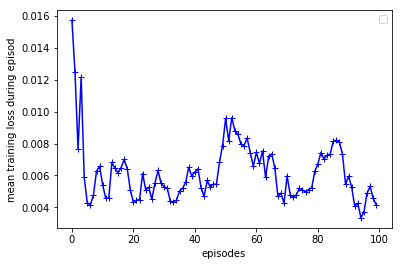

No handles with labels found to put in legend.


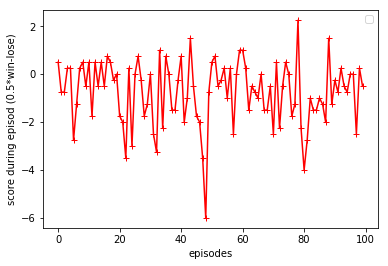

In [31]:
plt.plot(history_losses_dqn_fc,marker="+",color="b",label="")
plt.xlabel("episodes") ; plt.ylabel("mean training loss during episod") ; plt.legend()
plt.show()

plt.plot(history_scores_dqn_fc,marker="+",color="r",label="")
plt.xlabel("episodes") ; plt.ylabel("score during episod (0.5*win-lose)") ; plt.legend()
plt.show()

***
***
__Question 8__ Implement the DQN training algorithm using a CNN (for example, 2 convolutional layers and one final fully connected layer).

In [32]:
class DQN_CNN(DQN):
    def __init__(self, lr=0.1, *args, **kwargs):
        super(DQN_CNN, self).__init__(*args,**kwargs)
                
        model = Sequential()
    
        model.add(Conv2D(8, (3, 3), activation='relu', input_shape=(5,5,self.n_state,)))
        model.add(Conv2D(16, (3, 3), activation='relu'))
        model.add(Flatten())
        model.add(Dense(self.n_action))

        model.summary()
        
        #opt = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        opt = sgd(lr=lr, decay=1e-4, momentum=0.0)
        model.compile(loss="mse", optimizer = opt)
        
        self.model = model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 3, 3, 8)           152       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 16)          1168      
_________________________________________________________________
flatten_5 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 68        
Total params: 1,388
Trainable params: 1,388
Non-trainable params: 0
_________________________________________________________________
Epoch 000/100 | Loss 0.0336 | Win/lose count 3.5/6.0 (-4.25)
Epoch 001/100 | Loss 0.0122 | Win/lose count 2.5/5.0 (-3.75)
Epoch 002/100 | Loss 0.0099 | Win/lose count 3.5/4.0 (-2.25)
Epoch 003/100 | Loss 0.0087 | Win/lose count 1.5/3.0 (-2.25)
Epoch 004/100 | Loss 0.0076 

NameError: name 'history_losses_dqn_cnn' is not defined

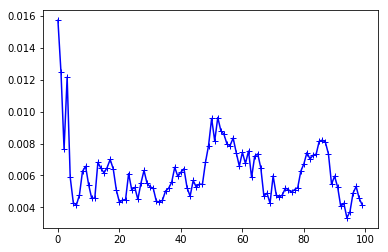

In [33]:
env = Environment(grid_size=size, max_time=T, temperature=temperature)
agent_dqn_cnn = DQN_CNN(grid_size=size, lr=.01, epsilon = 0.1, memory_size=2000, batch_size = 32)
history_losses_dqn_cnn, history_scores_dqn_cnn = train(agent_dqn_cnn,env,epochs_train,prefix='cnn_train')

plt.plot(history_losses_dqn_fc,marker="+",color="b",label="dqn_fc")
plt.plot(history_losses_dqn_cnn,marker="+",color="r",label="dqn_cnn")
plt.xlabel("episodes") ; plt.ylabel("mean training loss during episod") ; plt.legend()
plt.show()

plt.plot(history_scores_dqn_fc,marker="+",color="b",label="dqn_fc")
plt.plot(history_scores_dqn_cnn,marker="+",color="r",label="dqn_cnn")
plt.xlabel("episodes") ; plt.ylabel("score during episod (0.5*win-lose)") ; plt.legend()
plt.show()

HTML(display_videos('cnn_train10.mp4'))

***
***
__Question 9__ Test both algorithms and compare their performances. Which issue(s) do you observe? Observe also different behaviors by changing the temperature.

In [ ]:
agent_dqn_cnn = DQN_CNN(grid_size=size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 16)
agent_dqn_cnn.load(name_weights='cnn_trainmodel.h5',name_model='cnn_trainmodel.json')

agent_dqn_fc = DQN_FC(grid_size=size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 16)
agent_dqn_fc.load(name_weights='fc_trainmodel.h5',name_model='fc_trainmodel.json')

for temp in [0.1, 0.3, 0.5]:
    print("TEMPERATURE : ", str(temp))
    env = Environment(grid_size=size, max_time=T,temperature=temp)

    print('Test of the CNN')
    test(agent_dqn_cnn,env,epochs_test,prefix='cnn_test')
    print('Test of the FC')
    test(agent_dqn_fc,env,epochs_test,prefix='fc_test')

In [ ]:
HTML(display_videos('cnn_test10.mp4'))

In [ ]:
HTML(display_videos('fc_test10.mp4'))

#### TODO :comment

***

The algorithm tends to not explore the map which can be an issue. We propose two ideas in order to encourage exploration:
1. Incorporating a decreasing $\epsilon$-greedy exploration. You can use the method ```set_epsilon```
2. Append via the environment a new state that describes if a cell has been visited or not

***
__Question 10__ Design a new ```train_explore``` function and environment class ```EnvironmentExploring``` to tackle the issue of exploration.



In [ ]:
def train_explore(agent,env,epoch,prefix=''):
    
    decrease_rate_epsilon = (agent.epsilon-0.1)/epoch 
    #we decide that at the end of the training, epsilon is equal to 0.1
    
    history_losses = []
    history_scores = []    
    
    score = 0
    
    for e in range(epoch):
            
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False
        
        loss = 0

        win = 0
        lose = 0
        
        t = 0

        while not game_over:
            
            # The agent performs an action
            action = agent.act(state, train = True)

            # Apply an action to the environment, get the next state, the reward
            prev_state = state
            state, reward, game_over = env.act(action)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward

            # Apply the reinforcement strategy
            loss += agent.reinforce(prev_state, state,  action, reward, game_over)
            
            t+=1
            
        loss /= t
            
        history_losses.append(loss)

        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix+str(e))

        # Update stats
        score_episode = 0.5*win-lose
        score += score_episode
        history_scores.append(score_episode)
        
        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
              .format(e, epoch, loss, win, lose, score_episode))
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')
        
        ############
        #Update epsilon
                
        agent.set_epsilon(agent.epsilon-decrease_rate_epsilon)

                
class EnvironmentExploring(Environment):
    
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        
        super(EnvironmentExploring, self).__init__(grid_size=grid_size, max_time=max_time, temperature=temperature)
        self.is_visited = np.zeros((self.grid_size,self.grid_size)) #has the cell been visited by the past

    def act(self, action):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[:, -2:] = -1 #self.position[-2:, :] = -1

        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size-3:
                self.x = self.x -1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x +1
            else:
                self.x = self.x - 1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        reward = self.board[self.x, self.y]
        
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        
        #the new state is visited
        self.is_visited[self.x,self.y] = 1
                
        #we have one more layer caracterizing a state now
        state = np.concatenate((self.is_visited.reshape(self.grid_size, self.grid_size,1),
                                self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        
        #state visible for the rat
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]
        
        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]


        bonus = 0.5*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size,self.grid_size)

        malus = -1.0*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))


        malus[bonus>0]=0

        self.board = bonus + malus

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[:, -2:] = -1
        
        self.board[self.x,self.y] = 0
        self.board[self.position < 0] = 0
        
        self.t = 0
        
        #the initial state is visited
        self.is_visited[self.x,self.y] = 1
        
        #we have one more layer caracterizing a state now
        state = np.concatenate((self.is_visited.reshape(self.grid_size, self.grid_size,1),
                                self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state

In [ ]:
# Training
env = EnvironmentExploring(grid_size=size, max_time=T, temperature=temperature)
#agent = DQN_CNN(grid_size = size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32,n_state=3)

#init epsilon is 0.9, it will decrease linearly through epochs to reach 0.1 at the end of training
agent_dqn_cnn_explore = DQN_CNN(grid_size=size, lr=.1, epsilon = 0.9, memory_size=2000, batch_size = 16,n_state=3)
train_explore(agent_cnn_explore, env, epochs_train, prefix='cnn_train_explore')

In [ ]:
# Evaluation

test(agent_dqn_cnn_explore,env,epochs_test,prefix='cnn_test_explore')
HTML(display_videos('cnn_test_explore10.mp4'))

# Comparison

agent_dqn_cnn_explore = DQN_CNN(grid_size=size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 16)
agent_dqn_cnn_explore.load(name_weights='cnn_train_exploremodel.h5',name_model='cnn_train_exploremodel.json')

for temp in [0.1, 0.3, 0.5]:
    print("TEMPERATURE : ", str(temp))
    env = Environment(grid_size=size, max_time=T,temperature=temp)

    print('Test of the CNN (train with epsilon constant 0.9)')
    test(agent_dqn_cnn,env,epochs_test)
    print('Test of the CNN (train with decreasing epsilon from 0.9 to 0.1)')
    test(agent_dqn_cnn_explore,env,epochs_test)

***
***
__BONUS question__ Use the expert DQN from the previous question to generate some winning games. Train a model that mimicks its behavior. Compare the performances.

##### TODO : http://ciml.info/dl/v0_99/ciml-v0_99-ch18.pdf

***

In [ ]:
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

class Mimicker():
    
    def __init__(self, n_state=2, n_action=4):
        
        # number of action
        self.n_action = n_action
        
        # number of state
        self.n_state = n_state
        
        # Batch size when learning
                
        model = Sequential()
    
        model.add(Conv2D(8, (3, 3), activation='relu', padding='same',input_shape=(5,5,self.n_state,)))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(self.n_action),activation='softmax')

        model.summary()
        
        opt = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        #opt = sgd(lr=lr, decay=1e-4, momentum=0.0)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        
        self.model = model
    
    def act(state):
        return np.argmax(model.predict(state)) #action with highest probability
        
    def learn(trajectories,epochs=100,batch_size=16,prefix='', viz=True):
        
        states = []
        actions = []
        for (state, action) in trajectories:
            states.append(state)
            actions.append(action)
            
        label_actions = to_categorical(actions,num_classes=self.n_action)
        
        early_stopping_monitor = EarlyStopping(patience = 5)
        
        history = self.model.fit(states,actions,
                                 batch_size=batch_size,epochs=epochs,
                                 validation_split = 0.2,callbacks=[early_stopping_monitor],
                                 verbose=1)
        
        if viz:
            plt.plot(list(range(epochs)),history.history['loss'])
            plt.xlabel("epochs") ; plt.ylabel("train loss")
            plt.show()
            plt.plot(list(range(epochs)),history.history['val_loss'])
            plt.xlabel("epochs") ; plt.ylabel("validation loss")
            plt.show()

        self.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')

    def save(self,name_weights='model.h5',name_model='model.json'):
        self.model.save_weights(name_weights, overwrite=True)
        with open(name_model, "w") as outfile:
            json.dump(self.model.to_json(), outfile)
            
    def load(self,name_weights='model.h5',name_model='model.json'):
        with open(name_model, "r") as jfile:
            model = model_from_json(json.load(jfile))
        model.load_weights(name_weights)
        
        #model.compile("sgd", "mse")
        model.compile("adam", "mse")
        
        self.model = model

In [ ]:
epochs_test = 10
trajectories = test(agent_cnn_explore,env,epochs_test,prefix='cnn_test_explore')

agent_mimicker = Mimicker(n_state=2, n_action=4)
agent_mimicker.learn(trajectories,epochs=100,batch_size=16,prefix='mimicker_train', viz=True)

# Evaluation

test(agent_mimicker,env,epochs_test,prefix='mimicker_test')
HTML(display_videos('mimicker_test10.mp4'))

# Comparison performances

epochs_test = 10

for temp in [0.1, 0.3, 0.5]:
    print("TEMPERATURE : ", str(temp))
    env = Environment(grid_size=size, max_time=T,temperature=temp)

    print('Test of the CNN (train with decreasing epsilon from 0.9 to 0.1)')
    test(agent_dqn_cnn_explore,env,epochs_test)
    
    print('Test of the Mimicker Agent')
    test(agent_mimicker,env,epochs_test)